# Performance comparison of inference on pancreatic endocrine dataset

Notebook for comparison of terminal state identification

## Library imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib import rcParams

import cellrank as cr
import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking._tsi import plot_TSI, TSI_score
from rgv_tools.core import METHOD_PALETTE_TSI
from rgv_tools.plotting._significance import add_significance, get_significance

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "pancreatic_endocrine"

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [4]:
VELOCITY_METHODS = ["regvelo", "scvelo", "velovi"]

In [5]:
TERMINAL_STATES = ["Alpha", "Beta", "Delta", "Epsilon"]

## Data loading

In [6]:
ks = {}

for method in VELOCITY_METHODS:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_{method}.h5ad")
    ## construct graph
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

    kernel = 0.8 * vk + 0.2 * ck
    ks[method] = kernel

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

## Terminal state identification

In [7]:
thresholds = np.linspace(0.1, 1, 21)[:20]
estimators = {}
tsi = {}

In [8]:
for method in VELOCITY_METHODS:
    estimators[method] = cr.estimators.GPCCA(ks[method])
    tsi[method] = TSI_score(adata, thresholds, "clusters", TERMINAL_STATES, estimators[method])

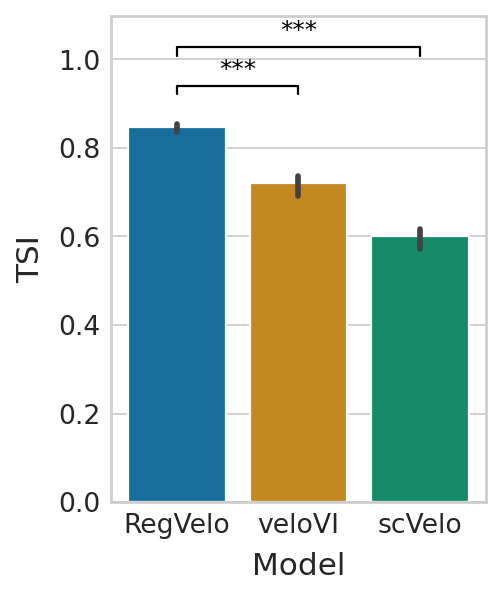

In [9]:
df = pd.DataFrame(
    {
        "TSI": tsi["regvelo"] + tsi["velovi"] + tsi["scvelo"],
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20,
    }
)
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)

    ttest_res = ttest_ind(tsi["regvelo"], tsi["velovi"], alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(tsi["regvelo"], tsi["scvelo"], alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9)

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "TSI_benchmark_update.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

In [10]:
ttest_ind(tsi["regvelo"], tsi["scvelo"], alternative="greater")

Ttest_indResult(statistic=16.77521564088505, pvalue=1.8515413304611978e-19)

## Show the stair plot

In [11]:
tsi_rgv_curve = plot_TSI(adata, estimators["regvelo"], 0.8, TERMINAL_STATES, "clusters")
tsi_scv_curve = plot_TSI(adata, estimators["scvelo"], 0.8, TERMINAL_STATES, "clusters")
tsi_vi_curve = plot_TSI(adata, estimators["velovi"], 0.8, TERMINAL_STATES, "clusters")

In [12]:
adata.shape

(3696, 1115)

In [13]:
### plot the recovery figure
df = pd.DataFrame(
    {
        "number_macrostate": range(0, 12),
        "RegVelo": [0] + tsi_rgv_curve,
        "veloVI": [0] + tsi_vi_curve,
        "scVelo": [0] + tsi_scv_curve,
    }
)
df = pd.melt(df, ["number_macrostate"])

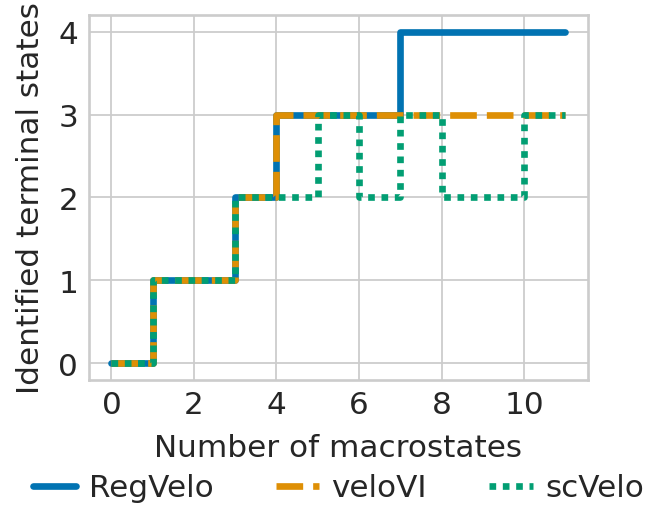

In [14]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    rcParams["figure.figsize"] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(
        x="number_macrostate",
        y="value",
        hue="variable",
        style="variable",
        palette=METHOD_PALETTE_TSI,
        drawstyle="steps-post",
        data=df,
        linewidth=3,
    )

    # Set labels and titles
    ax.set(ylabel="Number of correct predictions")
    plt.xlabel("Number of macrostates", fontsize=14)
    plt.ylabel("Identified terminal states", fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_xticklabels([0, 2, 4, 6, 8, 10])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4, fontsize=14)

    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / DATASET / "state_identification.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()